1  Подготовка:
 - 1.1  Ресемплирование
 
2  Анализ:
 - 2.1  Скользящее среднее
 - 2.2  Тренды и сезонность
 - 2.3  Вывод
 
3  Обучение:
 - 3.1  Линейная регрессия
 - 3.2  Вывод
 
4  Тестирование:
 - 4.1  Вывод


#  Прогнозирование заказов такси

Компания «Ч.т.» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно проанализировать данные и спрогнозировать количество заказов такси на следующий час. 

In [ ]:
!pip install optuna

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor
import optuna.integration.lightgbm as lgb
pd.options.display.max_columns = None

C:\Users\Professional\anaconda3\envs\praktikum_env_win_new\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
try:
     df_prim = pd.read_csv('C:/Users/Professional/praktikum/jupyter/временные_ряды/taxi.csv', parse_dates=['datetime'], index_col='datetime') 
except:
     df_prim = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

In [3]:
df_prim.sort_index(inplace=True)
df_prim.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
df_prim.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

Ресемлирование временных данных по одному часу

In [5]:
df = df_prim.resample('1H').sum()

df.head(30)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


## Анализ

### Скользящее среднее

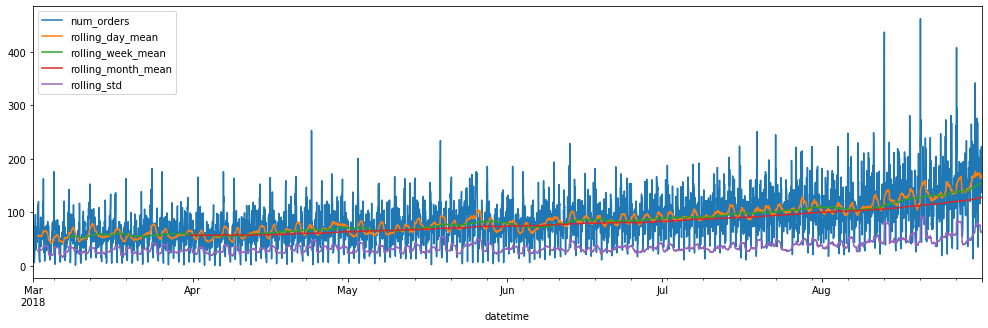

In [6]:
df['rolling_day_mean'] = df['num_orders'].rolling(24).mean()
df['rolling_week_mean'] = df['num_orders'].rolling(168).mean()
df['rolling_month_mean'] = df['num_orders'].rolling(732).mean()
df['rolling_std'] = df['num_orders'].rolling(24).std()  
df.plot(figsize=(17,5))

### Тренды и сезонность

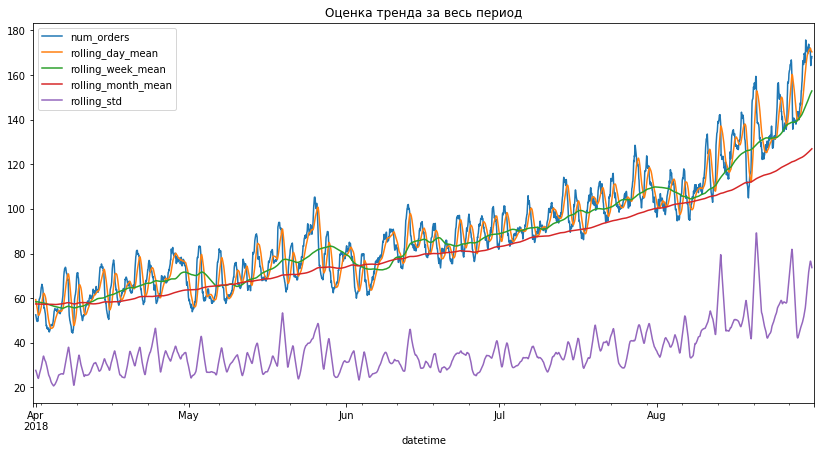

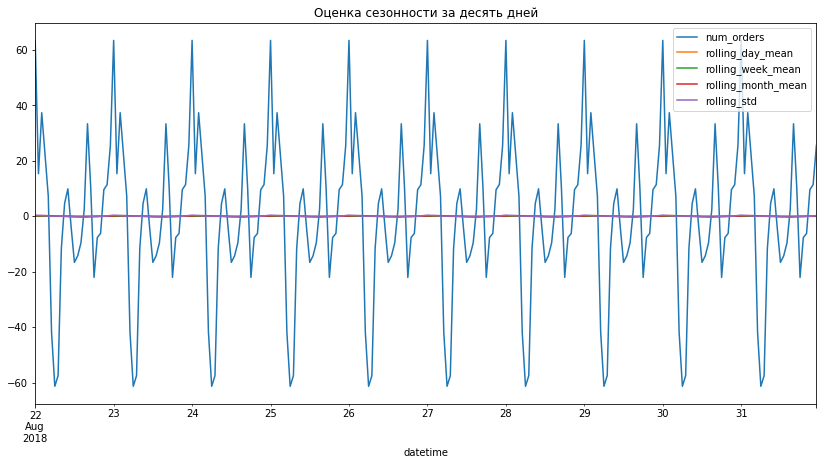

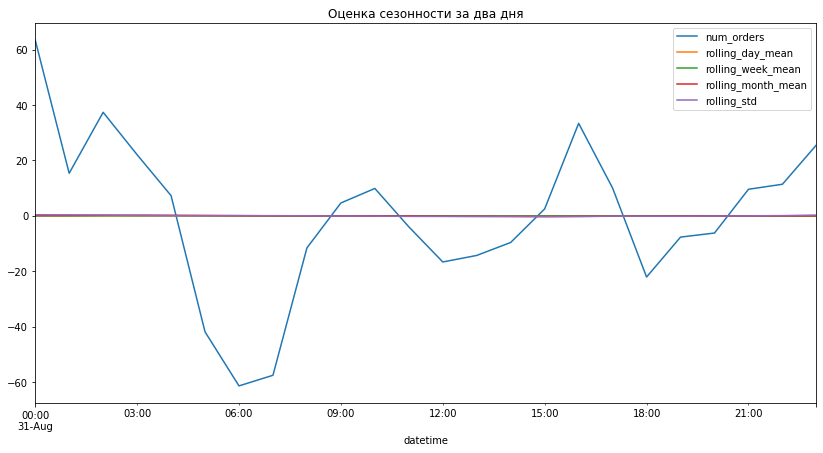

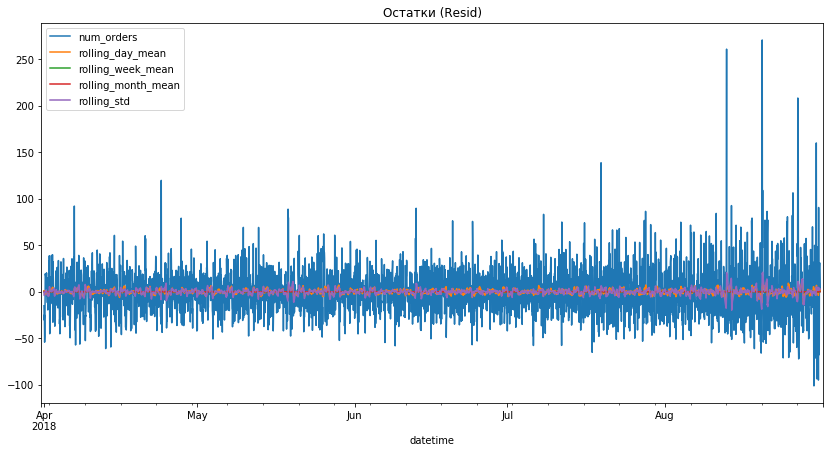

In [7]:
decomposed_data = seasonal_decompose(df.dropna())

decomposed_data.trend.plot(figsize=(14,7), 
                           title='Оценка тренда за весь период')

decomposed_data.seasonal.tail(24*10).plot(figsize=(14,7), 
                                         title='Оценка сезонности за десять дней')

decomposed_data.seasonal.tail(24*1).plot(figsize=(14,7), 
                                         title='Оценка сезонности за два дня')

decomposed_data.resid.plot(figsize=(14,7), title='Остатки (Resid)')

### Вывод

За наблюдаемый период количество заказов увеличивается;

Количество заказов не зависит от дня недели;

Количество заказов имеет выраженные различия в течении суток, максимум около полуночи, минииум в около 6 утра.

## Обучение

Создам новые признаки:
    
Час вызова такси - в виде категориальной переменной с преобразованием признаков OHE;

Значения за соответствующий час со сдвигом 2 недели.

In [8]:
for lag in range(1, 15):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag*24)

df['hour'] = df.index.hour

df['hour'] = df['hour'].astype("category")

df = pd.get_dummies(df, drop_first=True)

df = df.dropna()

df

,num_orders,rolling_day_mean,rolling_week_mean,rolling_month_mean,rolling_std,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-31 11:00:00,99,64.541667,58.273810,57.412568,29.405677,97.0,81.0,51.0,59.0,89.0,35.0,60.0,78.0,87.0,71.0,43.0,83.0,16.0,61.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-31 12:00:00,24,63.958333,58.136905,57.275956,30.086078,38.0,33.0,45.0,41.0,58.0,34.0,47.0,37.0,33.0,37.0,30.0,39.0,32.0,49.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2018-03-31 13:00:00,80,64.750000,58.375000,57.269126,30.254356,61.0,51.0,37.0,24.0,50.0,38.0,40.0,71.0,40.0,64.0,44.0,45.0,69.0,43.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2018-03-31 14:00:00,38,64.208333,58.375000,57.224044,30.625336,51.0,40.0,42.0,55.0,33.0,54.0,38.0,48.0,44.0,46.0,29.0,50.0,55.0,65.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2018-03-31 15:00:00,96,65.333333,58.482143,57.265027,31.297544,69.0,74.0,45.0,73.0,86.0,54.0,78.0,63.0,106.0,57.0,74.0,48.0,72.0,82.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,167.541667,154.434524,127.609290,63.268908,72.0,169.0,111.0,152.0,126.0,123.0,113.0,82.0,121.0,105.0,152.0,114.0,114.0,84.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2018-08-31 20:00:00,154,168.041667,154.285714,127.729508,63.105487,142.0,191.0,94.0,96.0,122.0,105.0,179.0,95.0,130.0,93.0,77.0,116.0,88.0,126.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2018-08-31 21:00:00,159,166.416667,154.244048,127.767760,62.801908,198.0,170.0,189.0,152.0,107.0,162.0,166.0,182.0,137.0,160.0,153.0,93.0,118.0,144.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Разделение на выборки

In [9]:
features = df.drop('num_orders', axis=1)
target = df['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.2, shuffle=False)

In [10]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(2948, 41)
(737, 41)
(2948,)
(737,)


In [11]:
target_test

datetime
2018-08-01 07:00:00     43
2018-08-01 08:00:00     66
2018-08-01 09:00:00    131
2018-08-01 10:00:00     75
2018-08-01 11:00:00     90
                      ... 
2018-08-31 19:00:00    136
2018-08-31 20:00:00    154
2018-08-31 21:00:00    159
2018-08-31 22:00:00    223
2018-08-31 23:00:00    205
Freq: H, Name: num_orders, Length: 737, dtype: int64

Для оценки адекватности моделей, создадим "предсказание" по вчерашнему дню

In [12]:
def rmse(target, predict):
    return (mean_squared_error(target, predict)) ** 0.5

In [13]:
custom_scorer = make_scorer(rmse, greater_is_better=False)

In [14]:
df_yesterday_train, df_yesterday_test =train_test_split(df, test_size = 0.2, shuffle=False)

df_yesterday_test['yesterday'] = df_yesterday_test['num_orders'].shift(24)
df_yesterday_test = df_yesterday_test.dropna()

rmse_yesterday = rmse(df_yesterday_test['num_orders'], df_yesterday_test['yesterday'])
print("RMSE предсказаний по вчерашнему дню:", round(rmse_yesterday, 3))

RMSE предсказаний по вчерашнему дню: 52.012


### Линейная регрессия

In [15]:
%%time
model = LinearRegression()
RMSE = pd.Series(cross_val_score(
    model, features_train, target_train, scoring=custom_scorer, cv=4)).mean()
print('RMSE', RMSE)

RMSE -20.23584334379114
Wall time: 112 ms


In [16]:
%%time
dtrain = lgb.Dataset(features_train, label=target_train)
params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt"
    
}

tuner = lgb.LightGBMTunerCV(params, dtrain, verbose_eval=250, early_stopping_rounds=250, folds=KFold(n_splits=3))

tuner.run()

best_score = tuner.best_score
print("RMSE:", best_score)
best_params = tuner.best_params
print("Оптимальные параметры модели:", best_params)

[250]	cv_agg's rmse: 21.3647 + 2.14922
RMSE: 20.77500274634416
Оптимальные параметры модели: {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 5.3995653353726936e-05, 'lambda_l2': 5.00560698305074e-05, 'num_leaves': 17, 'feature_fraction': 0.4, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20}
Wall time: 1min 6s


### Вывод
На тренировочной выборке лучше себя показала модель линейной регрессии, с RMSE 20.2.
Обе модели показали себя лучше, чем предсказание по вчерашнему дню.

## Тестирование

RMSE = 35.85577520064576


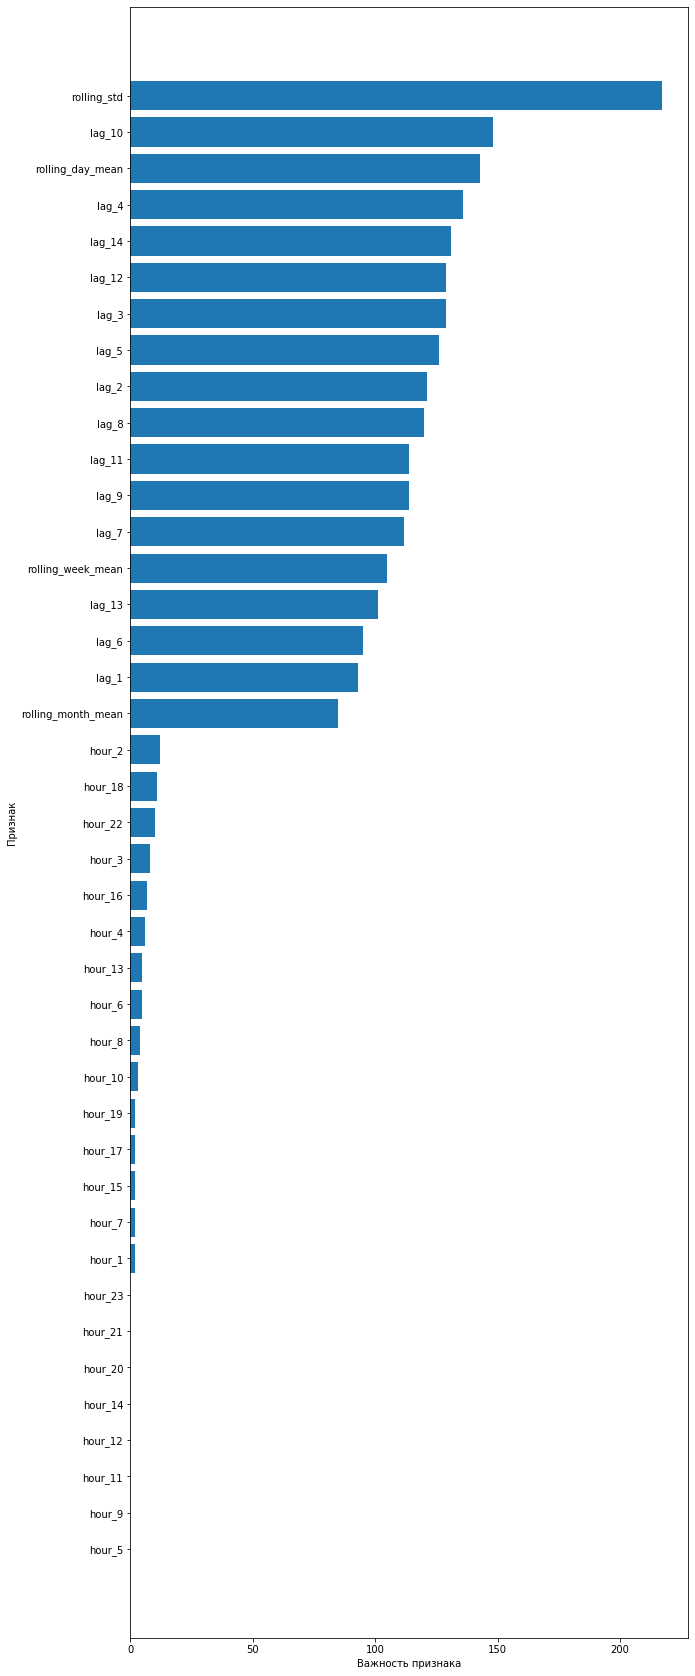

Wall time: 581 ms


<module 'matplotlib.pyplot' from 'C:\\Users\\Professional\\anaconda3\\envs\\praktikum_env_win_new\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [17]:
%%time
import matplotlib.pyplot as plt
model = LGBMRegressor(random_state=12345, num_leaves=24, min_child_samples=25)
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("RMSE =", rmse(target_test, predicted_test))
x = {}
for name, score in zip(features_train.columns.values, model.feature_importances_):
    x[name] = score
x = dict(sorted(x.items(), key=lambda item: item[1]))
names = list(x.keys())
values = list(x.values())
plt.rcParams["figure.figsize"] = (10, 30)
plt.barh(range(len(x)), values, tick_label=names, align='center')
plt.xlabel("Важность признака") 
plt.ylabel("Признак")
plt.show()

plt

RMSE = 31.892320678872203


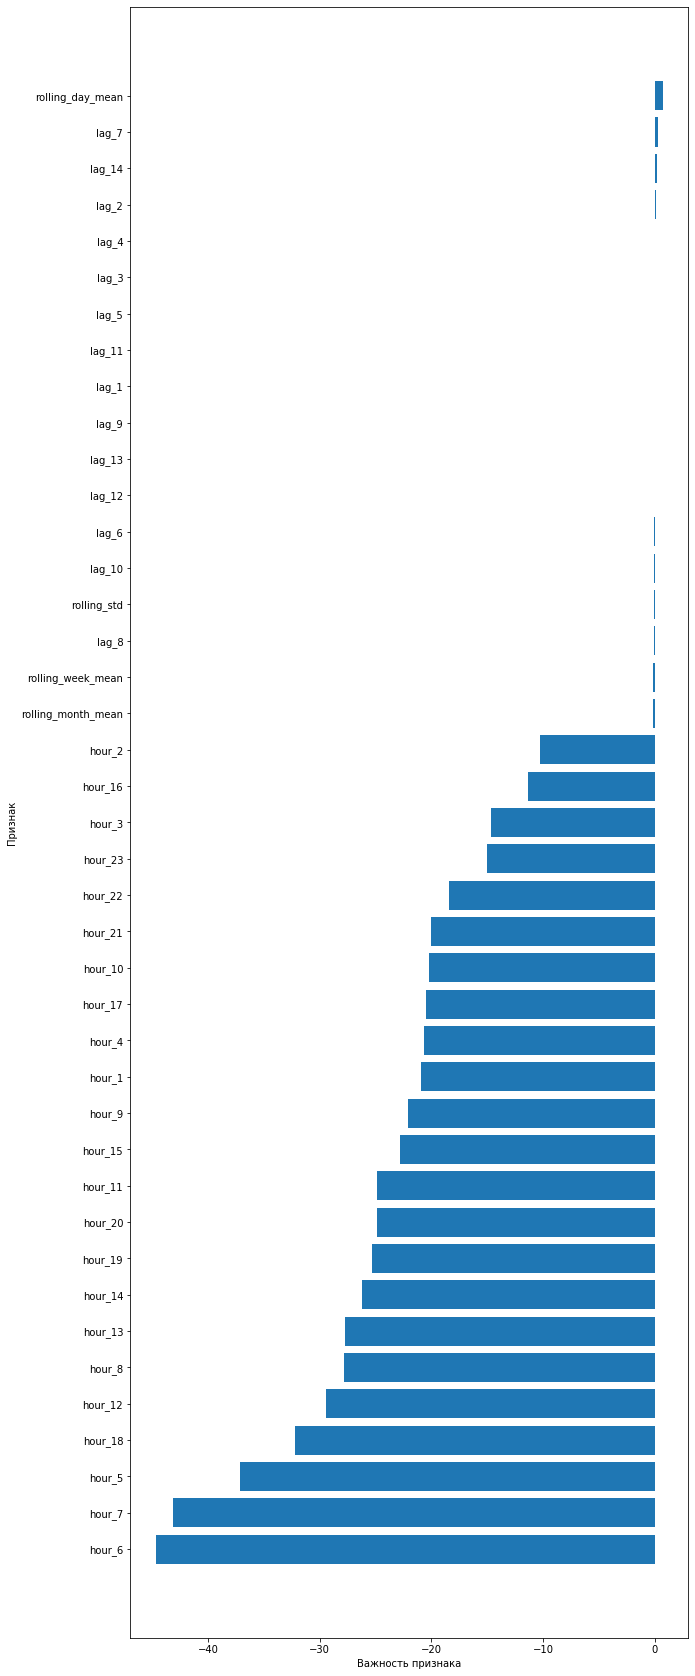

In [18]:
model = LinearRegression().fit(features_train, target_train)
print("RMSE =", rmse(target_test, model.predict(features_test)))

x = {}
for name, score in zip(features_train.columns.values, model.coef_):
    x[name] = score
x = dict(sorted(x.items(), key=lambda item: item[1]))
names = list(x.keys())
values = list(x.values())
plt.rcParams["figure.figsize"] = (10, 30)
plt.barh(range(len(x)), values, tick_label=names, align='center')
plt.xlabel("Важность признака") 
plt.ylabel("Признак")
plt.show()


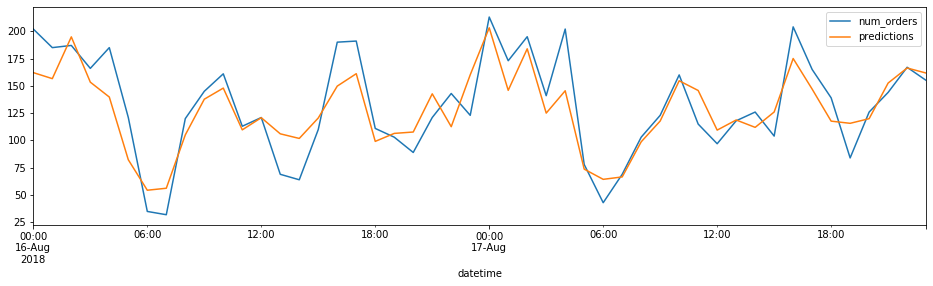

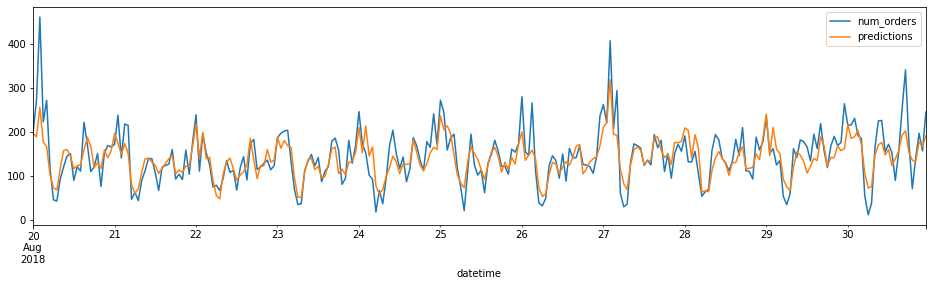

In [44]:
test = target_test.copy()
predictions_taxi = pd.DataFrame(data = model.predict(features_test), columns = ['predictions'], index = features_test.index.copy())
df_out = pd.merge(test, predictions_taxi, left_index = True, right_index = True)

df_out['2018-08-16':'2018-08-17'].plot(figsize=(16,4))
plt.show()
df_out['2018-08-20':'2018-08-30'].plot(figsize=(16,4))

### Вывод
Лучшая модель - линейная регрессия с RMSE на тестовой выборке 31.89